# References:
* https://www.youtube.com/watch?v=WxQfQW48A4A
* https://www.kaggle.com/thimac/ppo-lunar-lander-reinforcement-learning
* https://github.com/nric/ProximalPolicyOptimizationKeras
* https://github.com/rlcode/reinforcement-learning/tree/master/2-cartpole/4-actor-critic

In [1]:
!apt-get install -y python-opengl
!apt-get install -y ffmpeg

from IPython.display import clear_output
clear_output()

from xvfbwrapper import Xvfb

vdisplay = Xvfb(width=1280, height=740)
vdisplay.start()
print('Done')

Done


In [2]:
import gym
import pylab
import time
import itertools
import numpy as np
import seaborn as sns
from statistics import mean

import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import Math, HTML

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, load_model, Model

from keras import backend as K

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

Using TensorFlow backend.


In [3]:
GAMMA = 0.99
EPISODES = 1000
LR_ACTOR = 0.001
LR_CRITIC = 0.005

EPOCHS = 4
MINI_BATCH_SIZE = 16
BATCH_SIZE = EPOCHS * MINI_BATCH_SIZE

CLIPPING = 0.1
ENTROPY_BETA = 0.001

# smoothing factor
ALPHA = 0.95

env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

In [4]:
def create_animation(frames):
    rc('animation', html='jshtml')
    fig = plt.figure()
    plt.axis("off")
    im = plt.imshow(frames[0], animated=True)

    def updatefig(i):
        im.set_array(frames[i])
        return im,

    ani = animation.FuncAnimation(fig, updatefig, frames=len(frames), interval=20, blit=True)
    display(HTML(ani.to_html5_video()))    
    plt.close()    
    
    return ani

In [5]:
def plot_reward_history(rewards, lr_actor, lr_critic, save_to_file):
    plt.figure(0)
    plt.cla()
    ax = sns.lineplot(data=np.array(rewards))
    plt.show()
    
    if save_to_file:
        plt.figure(0).savefig(str(lr_actor) + '-' + str(lr_critic) + '.png')

In [6]:
def normalize(x):
    x -= x.mean()
    x /= (x.std() + 1e-8)
    return x

In [7]:
def ppo_loss_function(advantage, old_prediction):
    def loss(y_true, y_pred):
        # y_true one hot encoded actions
        # pred is a softmax vector. 
        # prob is the probability of the taken aciton.
        prob = y_true * y_pred
        old_prob = y_true * old_prediction

        # create the ratio based on log probability
        ratio = K.exp(K.log(prob + 1e-10) - K.log(old_prob + 1e-10))

        clip_ratio = K.clip(ratio, min_value=(1 - CLIPPING), max_value=(1 + CLIPPING))
        surrogate1 = ratio * advantage
        surrogate2 = clip_ratio * advantage

        # add the entropy loss to avoid getting stuck on local minima
        entropy_loss = (prob * K.log(prob + 1e-10))
        ppo_loss = -K.mean(K.minimum(surrogate1,surrogate2) + ENTROPY_BETA * entropy_loss)
        return ppo_loss

    return loss

In [8]:
class PPOAgent:
    def __init__(self, state_size, action_size, gamma=GAMMA, lr_actor=LR_ACTOR, lr_critic=LR_CRITIC, load_model_from_file=False):
        self.load_model_from_file = load_model_from_file

        self.gamma = gamma
        self.lr_actor = lr_actor
        self.lr_critic = lr_critic

        self.state_size = state_size
        self.action_size = action_size
        self.value_size = 1
        
        self.training_loss = []
        
        self.actor = self.build_actor()
        self.critic = self.build_critic()

        if self.load_model_from_file:
            self.actor.load_weights('cartpole_actor.h5')
            self.critic.load_weights('cartpole_critic.h5')
     
    def build_actor(self):
        advantage = Input(shape=(1,), name='advantage_input')
        old_prediction = Input(shape=(self.action_size,),name='old_prediction_input')
        loss = ppo_loss_function(advantage=advantage, old_prediction=old_prediction)
        
        state_input = Input(shape=self.state_size, name='state_input')
        serial = state_input
        serial = Dense(24, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform')(serial)
        output = Dense(self.action_size, activation='softmax', kernel_initializer='he_uniform')(serial)
        
        actor = Model(inputs=[state_input, advantage, old_prediction], outputs=[output])
        actor.compile(loss=[loss], optimizer=Adam(lr=self.lr_actor))
        # actor.summary()
        return actor

    def build_critic(self):
        critic = Sequential()
        critic.add(Dense(24, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        critic.add(Dense(self.value_size, activation='linear', kernel_initializer='he_uniform'))
        critic.compile(loss="mse", optimizer=Adam(lr=self.lr_critic))
        # critic.summary()
        return critic
    
    def get_value(self, state):
        state_expanded = np.reshape(state, [1, self.state_size])
        return self.critic.predict(state_expanded)[0][0]

    def get_action(self, state):
        state_expanded = np.reshape(state, [1, self.state_size])
        probability = self.actor.predict([state_expanded, np.zeros((1, 1)), np.zeros((1, self.action_size))])[0]
        action_idx = np.random.choice(self.action_size, 1, p=probability)[0]
        return action_idx, probability

    def one_hot_ecode_actions(self, actions):
        length = len(actions)
        result = np.zeros((length, self.action_size))
        result[range(length), actions] = 1
        return result
    
    def train_model(self, states, advantages, actions, probabilities, gaes):
        one_hot_encoded_actions = self.one_hot_ecode_actions(actions)

        actor_loss = self.actor.fit(
            [states, advantages, probabilities],
            [one_hot_encoded_actions],
            verbose=False, shuffle=True, epochs=EPOCHS, batch_size=MINI_BATCH_SIZE, validation_split=0.2)
        
        critic_loss = self.critic.fit(
            [states],
            [gaes],
            verbose=False, shuffle=True, epochs=EPOCHS, batch_size=MINI_BATCH_SIZE, validation_split=0.2)
        self.training_loss = [mean(actor_loss.history['val_loss']), mean(critic_loss.history['val_loss'])]

    def save_models(self):
        self.actor.save("cartpole_actor.h5")
        self.critic.save("cartpole_critic.h5")

In [9]:
def record_episode(agent):
    frames = []
    done = False
    
    state = env.reset()

    while not done:
        action, _ = agent.get_action(state)
        next_state, _, done, _ = env.step(action)
        state = next_state
        frames.append(env.render(mode="rgb_array"))

    ani = create_animation(frames)

In [10]:
def get_generalized_advantage_estimations(reward_mem, value_mem, mask_mem, next_state_value):
    gae = 0
    return_mem = []
    episode_length = len(reward_mem)
   
    for t in reversed(range(episode_length)):
        value = value_mem[t]
        value_prime = next_state_value if (t+1) >= episode_length else value_mem[t+1]
        
        delta = reward_mem[t] + GAMMA * value_prime * mask_mem[t] - value
        gae = delta + GAMMA * ALPHA * mask_mem[t] * gae
        
        return_value = gae + value  
        return_mem.insert(0, return_value)
        
    return np.array(return_mem)

In [11]:
def train_agent(nr_of_episodes=EPISODES, lr_actor=LR_ACTOR, lr_critic=LR_CRITIC, render=False):
    scores = []
    agent = PPOAgent(state_size, action_size, lr_actor=lr_actor, lr_critic=lr_critic)

    value_mem = []
    state_mem = []
    action_mem = []
    reward_mem = []
    mask_mem = []
    probability_mem = []
    
    try:
        for episode_idx in range(nr_of_episodes):
            done = False
            score = 0
            state = env.reset()

            while not done:
                value = agent.get_value(state)
                action, probability = agent.get_action(state)
                next_state, reward, done, _ = env.step(action)

                value_mem.append(value)
                state_mem.append(state)
                action_mem.append(action)
                reward_mem.append(reward)
                mask_mem.append(0 if done == True else 1)
                probability_mem.append(probability)

                score += reward
                state = next_state
                
                if done:
                    scores.append(score)
                    
                    if (episode_idx % 50) == 49:
                        mean_score = mean(scores[-10:])
                        print(episode_idx+1, 'Mean score:', mean_score, ', loss:', agent.training_loss)

                
                if len(state_mem) >= BATCH_SIZE:
                    # the value of this state is not yet added to the value memory
                    next_state_value = agent.get_value(state)

                    state_mem = np.array(state_mem)
                    value_mem = np.array(value_mem)
                    action_mem = np.array(action_mem)
                    probability_mem = np.array(probability_mem)
                    
                    gaes = get_generalized_advantage_estimations(reward_mem, value_mem, mask_mem, next_state_value)
                    advantages = gaes - value_mem
                    advantages = normalize(advantages)
  
                    agent.train_model(state_mem, advantages, action_mem, probability_mem, gaes)
                    
                    # reset buffers
                    value_mem = []
                    state_mem = []
                    action_mem = []
                    reward_mem = []
                    mask_mem = []
                    probability_mem = []
                    

            # stop the training and save the model when ever the last X runs are close to the optimum
            if len(scores) > 5 and np.mean(scores[-5:]) > 490:
                agent.save_models()
                return
    finally:
        plot_reward_history(scores, lr_actor=lr_actor, lr_critic=lr_critic, save_to_file=False)

In [12]:
agent = PPOAgent(state_size, action_size)
record_episode(agent)

LR Actor: 0.001 , LR Critic: 0.005
50 Mean score: 56.7 , loss: [1.2189003825187683, 11.311473608016968]
100 Mean score: 66.5 , loss: [-0.7799964398145676, 11.532566905021667]
150 Mean score: 249.7 , loss: [0.9646164178848267, 14.062007308006287]
200 Mean score: 436.3 , loss: [1.701282411813736, 0.9184574335813522]


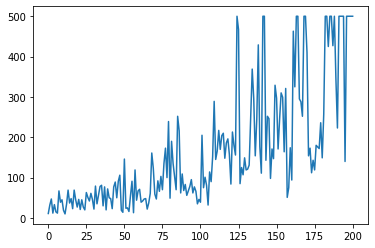

In [15]:
lrs_actor = [0.001]
lrs_critic = [0.005]

for r in itertools.product(lrs_actor, lrs_critic):
    lr_actor = r[0]
    lr_critic = r[1]
    print("LR Actor:", lr_actor, ", LR Critic:", lr_critic)
    train_agent(nr_of_episodes=1000, lr_actor=lr_actor, lr_critic=lr_critic)

In [16]:
agent = PPOAgent(state_size, action_size, load_model_from_file=True)
record_episode(agent)